In [1]:
cd ../../..

/home/ildefonso/Documents/ExtraDrive/repos/vocalpy/Nicholson-Cohen-2024-bio-sound-seg-bench-0.1


/home/ildefonso/Documents/ExtraDrive/repos/vocalpy/Nicholson-Cohen-2024-bio-sound-seg-bench-0.1/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from __future__ import annotations

from typing import Callable, Literal, Mapping

import collections
import dataclasses
import json
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import vak

import biosoundsegbench

In [3]:
splits_json_paths = sorted(biosoundsegbench.prep.constants.SPLITS_JSONS_DIR.glob('*.json'))
splits_json_path = splits_json_paths[0]


In [4]:
def fit_inputs_targets_csv_path(cls, 
                                inputs_targets_csv_path: str | pathlib.Path,
                                dataset_path: str | pathlib.Path,
                                split: str = 'train',
                                subset: str | None = None,
                                frames_path_col_name: str = vak.datasets.frame_classification.constants.FRAMES_PATH_COL_NAME,
                                frames_key: str = vak.common.constants.SPECT_KEY):
    inputs_targets_csv_path = pathlib.Path(inputs_targets_csv_path)
    if not inputs_targets_csv_path.exists():
        raise FileNotFoundError(
            f"`inputs_targets_csv_path` for dataset not found: {inputs_targets_csv_path}"
        )

    dataset_path = pathlib.Path(dataset_path)
    if not dataset_path.exists() or not dataset_path.is_dir():
        raise NotADirectoryError(
            f"`dataset_path` not found, or not a directory: {dataset_path}"
        )

    df = pd.read_csv(inputs_targets_csv_path)
    if subset:
        df = df[df.split == split].copy()
    else:
        df = df[df.split == split].copy()
    frames_paths = df[
        frames_path_col_name
    ].values
    frames = np.load(dataset_path / frames_paths[0])[frames_key]

    # in spectrograms files, spectrograms are in orientation (freq bins, time bins)
    # so we take mean and std across columns, i.e. time bins, i.e. axis 1
    mean_freqs = np.mean(frames, axis=1)
    std_freqs = np.std(frames, axis=1)

    for frames_path in frames_paths[1:]:
        frames = np.load(dataset_path / frames_path)[frames_key]
        mean_freqs += np.mean(frames, axis=1)
        std_freqs += np.std(frames, axis=1)
    mean_freqs = mean_freqs / len(frames_paths)
    std_freqs = std_freqs / len(frames_paths)
    non_zero_std = np.argwhere(std_freqs != 0)
    return cls(mean_freqs, std_freqs, non_zero_std)

In [5]:
setattr(
    vak.transforms.StandardizeSpect,
    fit_inputs_targets_csv_path.__name__,
    classmethod(fit_inputs_targets_csv_path)
)

In [6]:
def plot_examples_train(
    splits_json_path,
    window_size=2000,
    target_type='multi_frame_labels',
    idx_start=0,
    idx_stop=20000,
    idx_step=4000,
    n_windows_to_plot=4,
    standardize=True,
):
    splits_metadata = biosoundsegbench.dataset.SplitsMetadata.from_paths(
        json_path=splits_json_path, dataset_path=biosoundsegbench.prep.constants.DATASET_ROOT
    )
    if standardize:
        spect_standardizer = vak.transforms.StandardizeSpect.fit_inputs_targets_csv_path(
            splits_metadata.splits_csv_path,
            biosoundsegbench.prep.constants.DATASET_ROOT
        )
    else:
        spect_standardizer = None
    train_transform = biosoundsegbench.transforms.item.TrainItemTransform(spect_standardizer)
    train_data_multi = biosoundsegbench.dataset.BioSoundSegBench(
        root=biosoundsegbench.prep.constants.DATASET_ROOT,
        splits_path=splits_json_path,
        split='train',
        item_transform=train_transform,
        window_size=window_size,
        target_type=target_type,
    )

    if isinstance(target_type, str):
        target_type = (target_type,)
    for window_n, idx in enumerate(range(idx_start ,idx_stop, idx_step)):
        if window_n + 1 > n_windows_to_plot:
            break
        item = train_data_multi[idx]
    
        fig, ax_arr = plt.subplots(1 + len(target_type), 1, sharex=True)
        frames = item['frames']
        x = np.arange(frames.shape[2])
        y = np.arange(frames.shape[1])
        ax_arr[0].pcolormesh(x, y, frames[0])
        for ind, target_type_ in enumerate(target_type):
            ax_arr[1 + ind].plot(x, item[target_type_])

In [7]:
def plot_examples_val(
    splits_json_path,
    target_type='multi_frame_labels',
    window_size: int = 2000,
    idx=0,
    n_windows_to_plot=5,
    standardize=True,
):
    splits_metadata = biosoundsegbench.dataset.SplitsMetadata.from_paths(
        json_path=splits_json_path, dataset_path=biosoundsegbench.prep.constants.DATASET_ROOT
    )
    if standardize:
        spect_standardizer = vak.transforms.StandardizeSpect.fit_inputs_targets_csv_path(
            splits_metadata.splits_csv_path,
            biosoundsegbench.prep.constants.DATASET_ROOT
        )
    else:
        spect_standardizer = None
    val_transform = biosoundsegbench.transforms.item.EvalItemTransform(
        spect_standardizer=spect_standardizer,
        window_size=window_size,
    )
    val_data_multi = biosoundsegbench.dataset.BioSoundSegBench(
        root=biosoundsegbench.prep.constants.DATASET_ROOT,
        splits_path=splits_json_path,
        split='val',
        item_transform=val_transform,
        target_type=target_type,
        window_size=window_size,
    )
    item = val_data_multi[idx]

    if isinstance(target_type, str):
        target_type = [target_type]
    zipped = list(zip(item['frames'], *(item[target_type] for target_type in target_type)))
    for tup in zipped[:n_windows_to_plot]:
        frames_ = tup[0]
        targets = tuple(tup[1:])
        fig, ax_arr = plt.subplots(1 + len(targets), 1, sharex=True)
        x = np.arange(frames_.shape[2])
        y = np.arange(frames_.shape[1])
        ax_arr[0].pcolormesh(x, y, frames_[0])
        for ind, target in enumerate(targets):
            ax_arr[1 + ind].plot(x, target)

In [8]:
training_replicate_metadata_json_path = pathlib.Path(
    './data/BioSoundSegBench/training-replicate-metadata.json'
)

In [9]:
with training_replicate_metadata_json_path.open('r') as fp:
    training_replicate_metadata = json.load(fp)

In [10]:
ALL_TRAINING_REPLICATES = [
    biosoundsegbench.prep.split.TrainingReplicateMetadata(
        **training_replicate_metadata_dict
    )
    for training_replicate_metadata_dict in training_replicate_metadata
]

In [11]:
import math


def get_training_replicate_metadata(
    biosound_group: str,
    timebin_dur: float,
    unit: str,
    train_dur: float,
    replicate_num: int,
    id_: str | None = None,
    data_source: str | None = None,
):
    query = biosoundsegbench.prep.split.TrainingReplicateMetadata(
        biosound_group,
        id_,
        timebin_dur,
        unit,
        data_source,
        train_dur,
        replicate_num,
        'dummy-path',
    )
    for replicate in ALL_TRAINING_REPLICATES:
        if (
            (replicate.biosound_group == query.biosound_group) and
            (replicate.id == query.id) and
            math.isclose(replicate.timebin_dur, query.timebin_dur, abs_tol=0.1) and
            (replicate.data_source == query.data_source) and
            math.isclose(replicate.train_dur, query.train_dur, abs_tol=0.1) and
            (replicate.replicate_num == query.replicate_num)         
        ):
            return replicate
    raise ValueError(
        f"Coulnd't find a training replicate with metadata that matched query: {query}"
    )

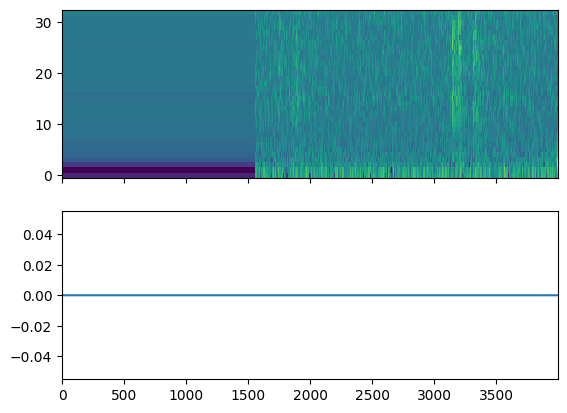

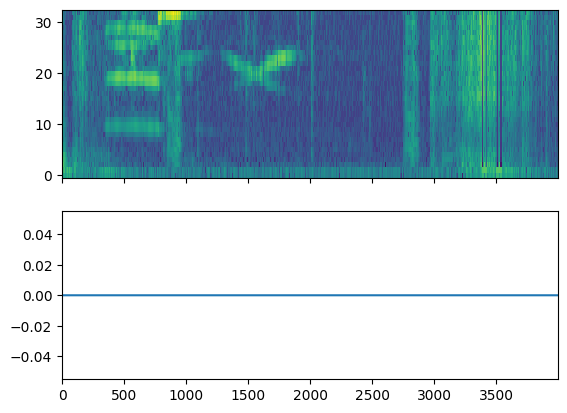

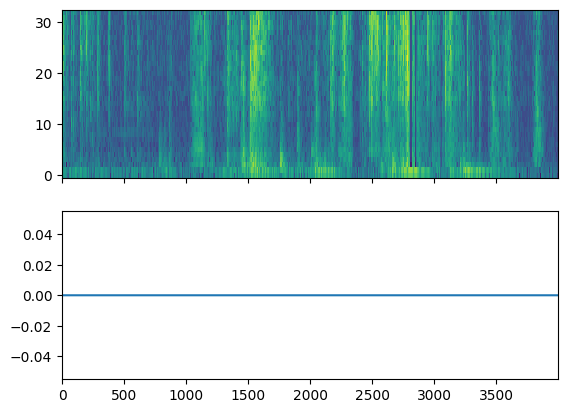

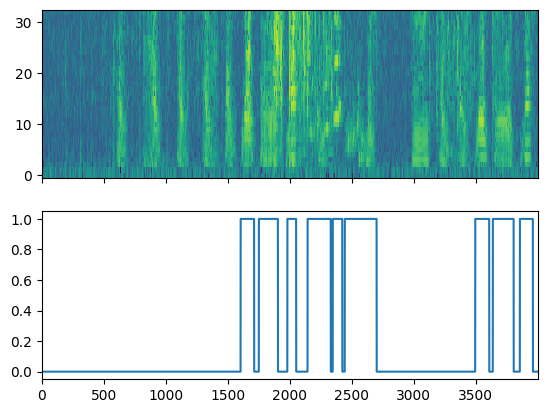

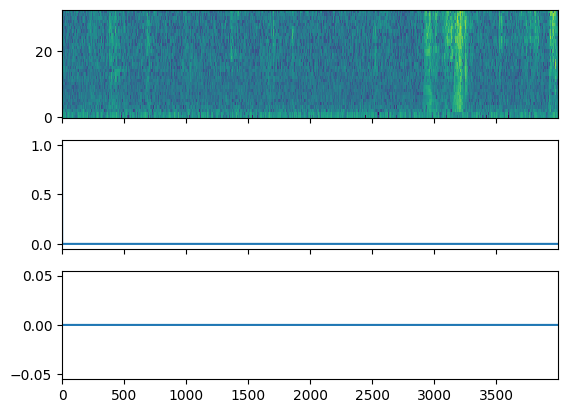

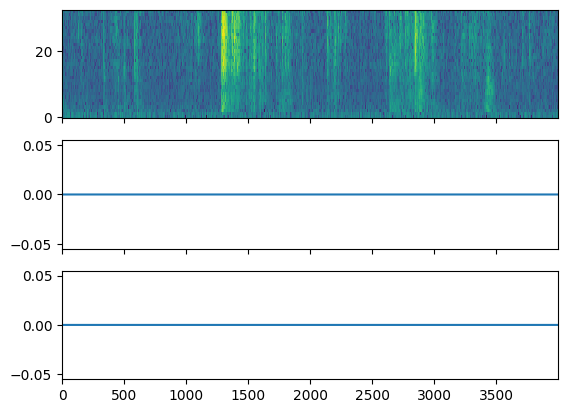

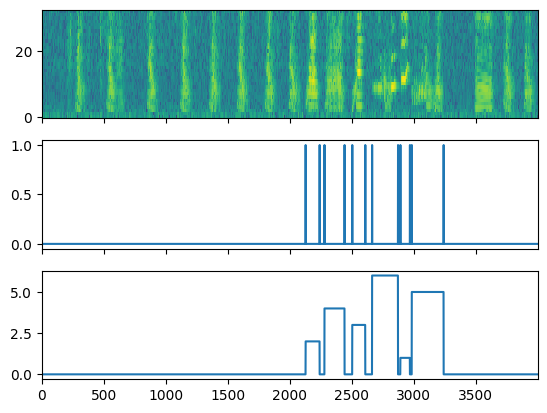

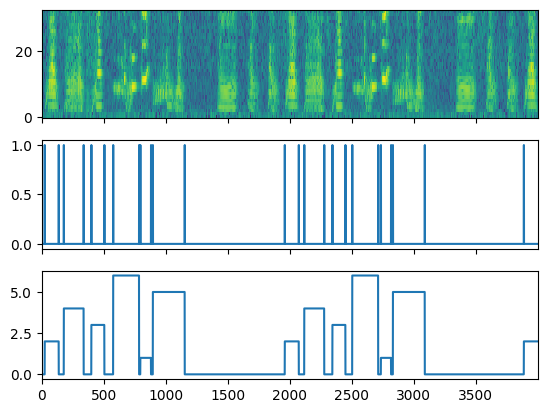

In [12]:
metadata = get_training_replicate_metadata(
    'Zebra-Finch-Song',
    0.5,
    'syllable',
    100.,
    3,
    'blu285',
    'id-data-only',
)
splits_json_path = biosoundsegbench.prep.constants.DATASET_ROOT / metadata.splits_json_path
plot_examples_train(
    splits_json_path,
    target_type='binary_frame_labels',
    n_windows_to_plot=4,
    window_size=4000,
)
plot_examples_val(
    splits_json_path,
    target_type=('boundary_onehot', 'multi_frame_labels'),
    window_size=4000,
    n_windows_to_plot=4,
)

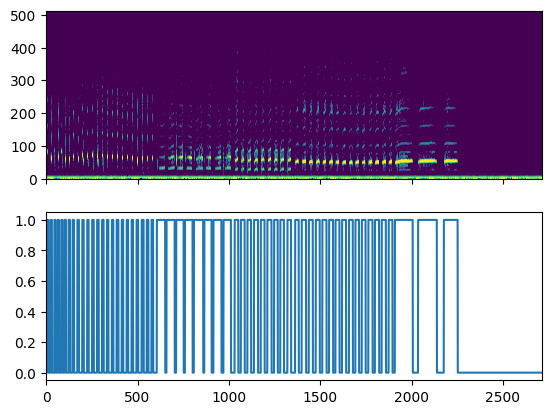

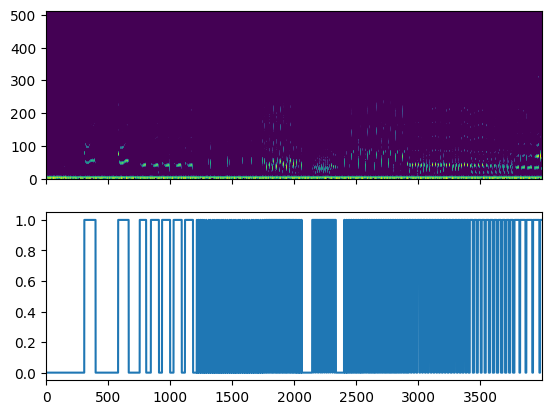

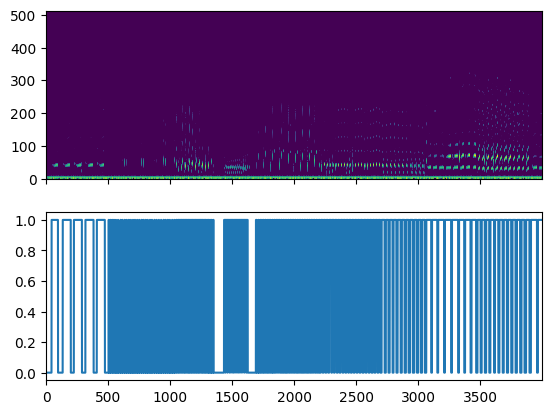

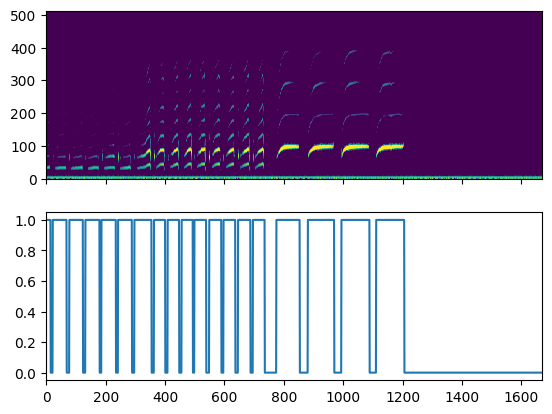

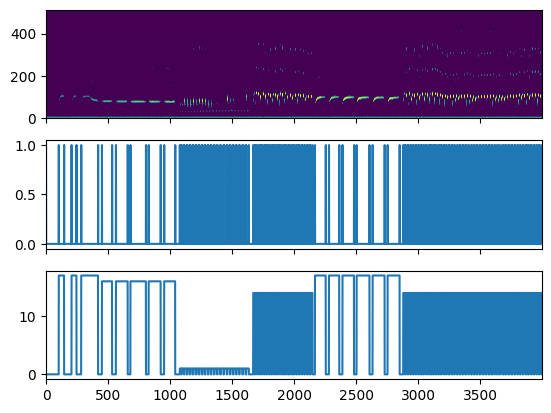

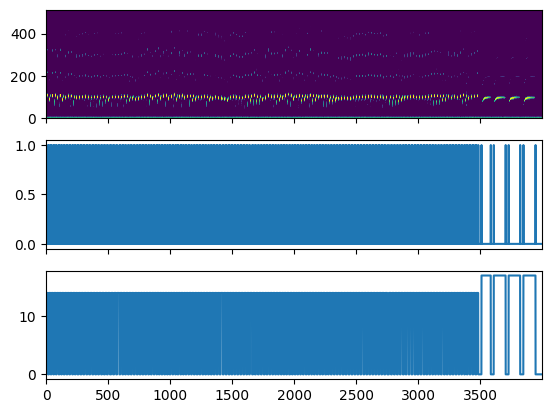

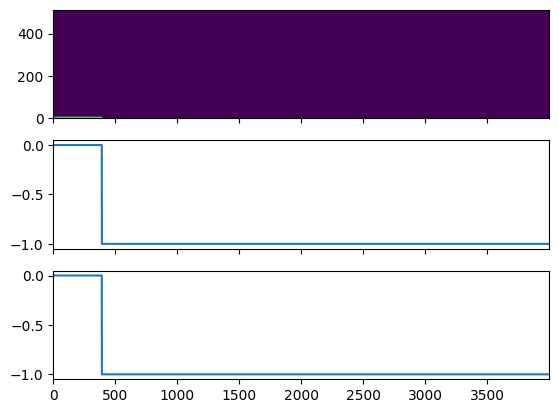

In [13]:
metadata = get_training_replicate_metadata(
    'Canary-Song',
    2.7,
    'syllable',
    3600.,
    1,
    'llb3',
    'id-data-only',
)
splits_json_path = biosoundsegbench.prep.constants.DATASET_ROOT / metadata.splits_json_path
plot_examples_train(
    splits_json_path,
    target_type='binary_frame_labels',
    n_windows_to_plot=4,
    window_size=4000,
    standardize=False,
)
plot_examples_val(
    splits_json_path,
    target_type=('boundary_onehot', 'multi_frame_labels'),
    window_size=4000,
    n_windows_to_plot=4,
    standardize=False,
)

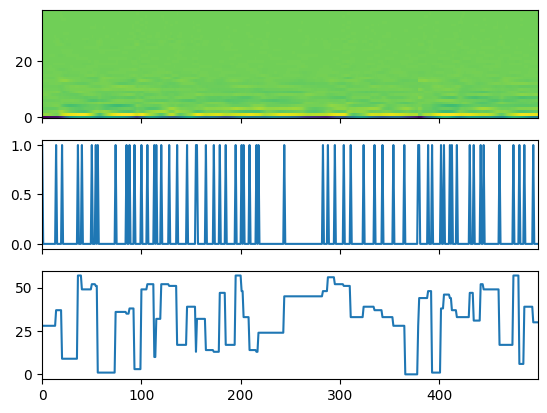

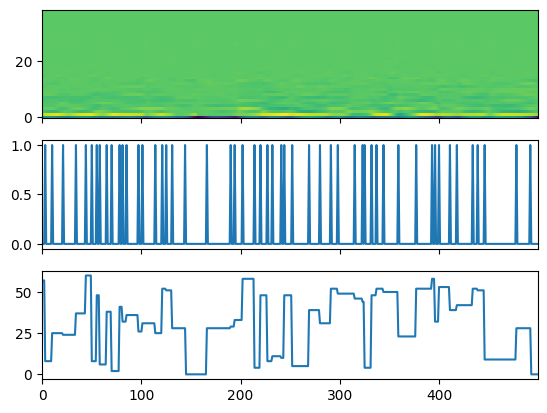

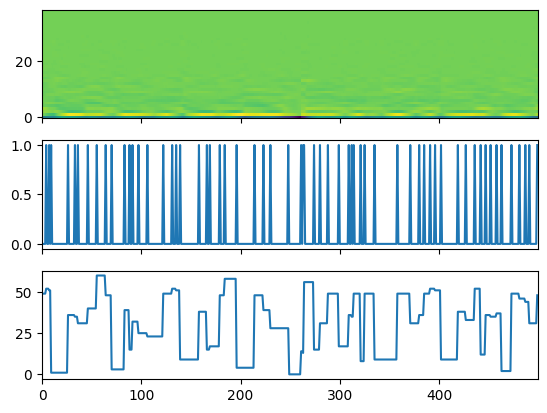

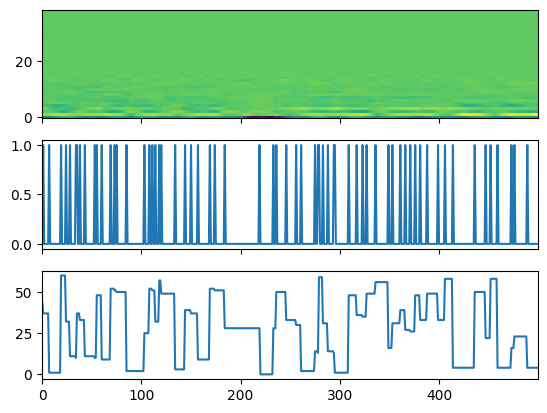

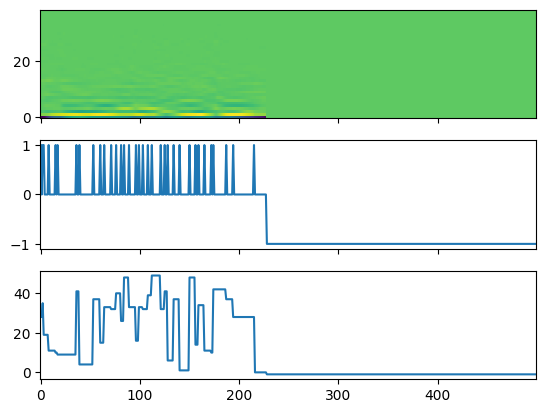

In [14]:
metadata = get_training_replicate_metadata(
    biosound_group='Human-Speech',
    timebin_dur=10.0,
    unit='phoneme',
    train_dur=16000.,
    replicate_num=1,
)
splits_json_path = biosoundsegbench.prep.constants.DATASET_ROOT / metadata.splits_json_path
plot_examples_train(
    splits_json_path,
    target_type=('boundary_onehot', 'multi_frame_labels'),
    n_windows_to_plot=4,
    window_size=500,
    standardize=False,
)
plot_examples_val(
    splits_json_path,
    target_type=('boundary_onehot', 'multi_frame_labels'),
    window_size=500,
    n_windows_to_plot=4,
    standardize=False,
)

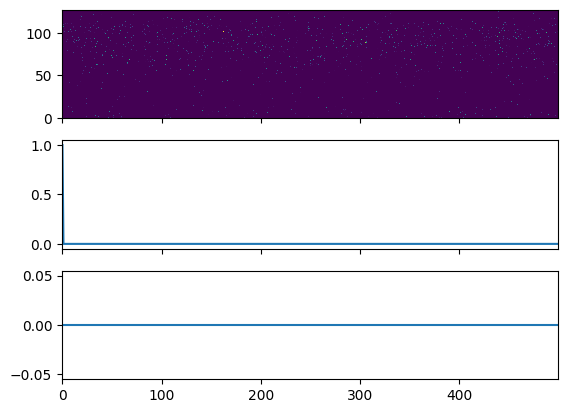

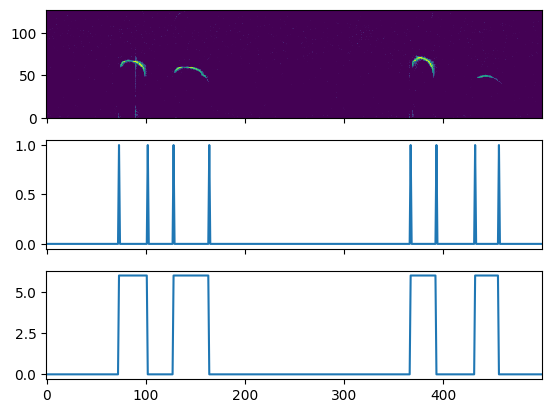

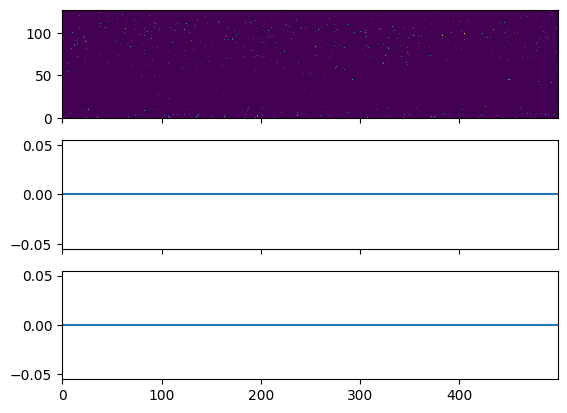

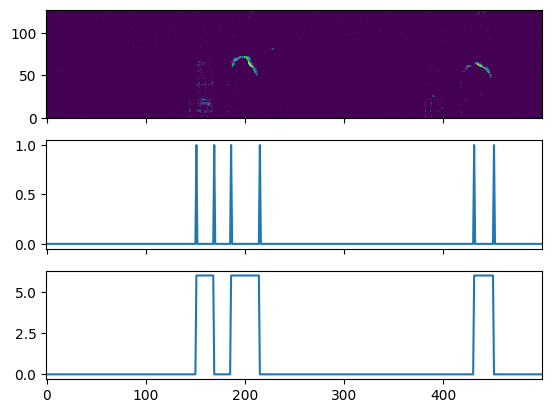

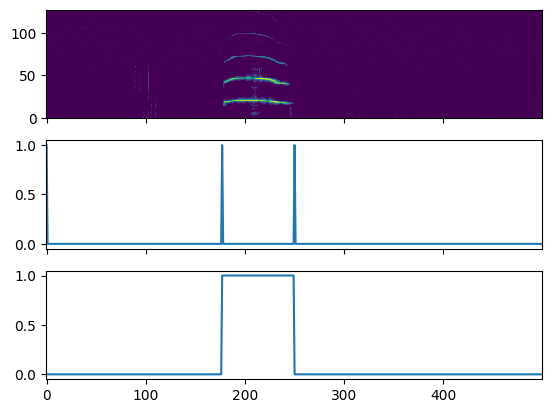

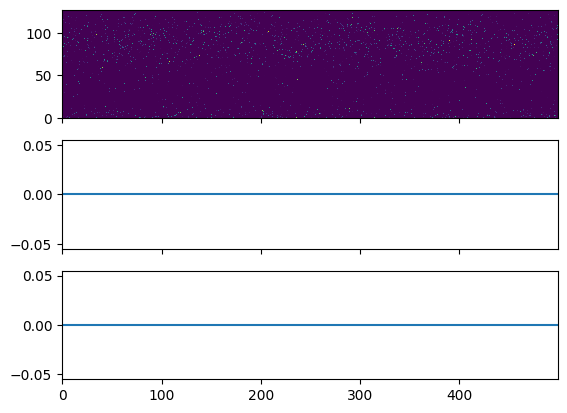

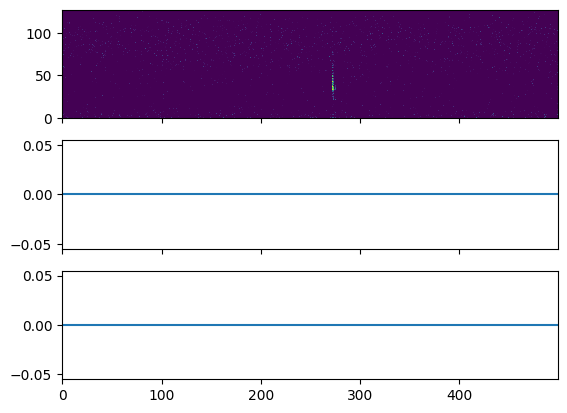

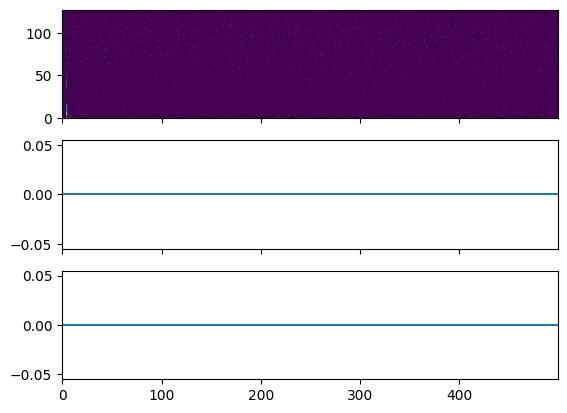

In [15]:
metadata = get_training_replicate_metadata(
    biosound_group='Mouse-Pup-Call',
    id_='BK',
    timebin_dur=1.5,
    unit='call',
    train_dur=1500.,
    replicate_num=1,
    data_source='leave-one-id-out',
)
splits_json_path = biosoundsegbench.prep.constants.DATASET_ROOT / metadata.splits_json_path
plot_examples_train(
    splits_json_path,
    target_type=('boundary_onehot', 'multi_frame_labels'),
    n_windows_to_plot=4,
    window_size=500,
    standardize=False,
)
plot_examples_val(
    splits_json_path,
    target_type=('boundary_onehot', 'multi_frame_labels'),
    window_size=500,
    n_windows_to_plot=4,
    standardize=False,
)

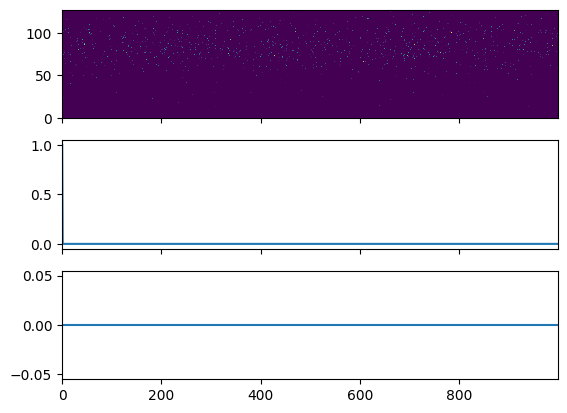

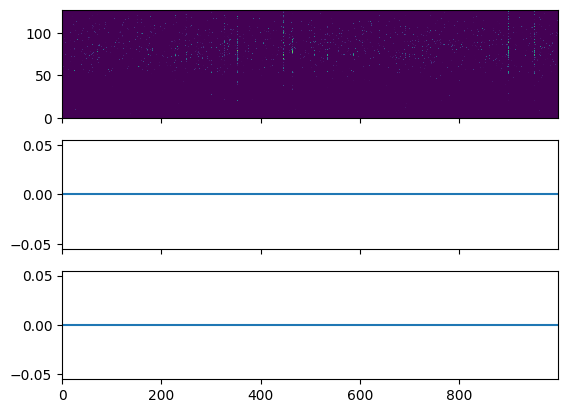

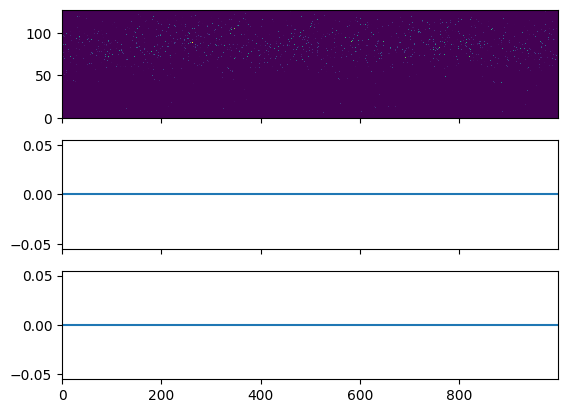

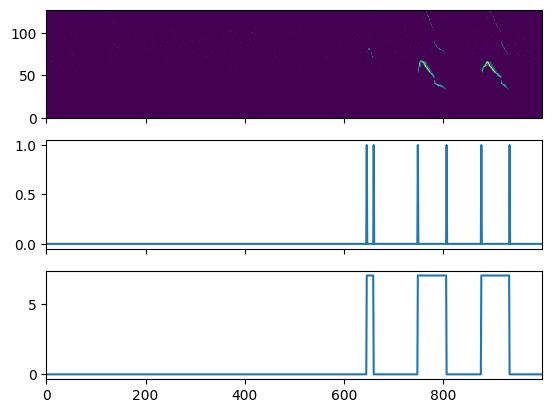

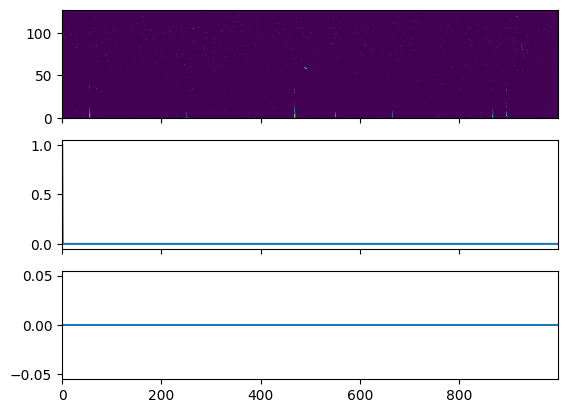

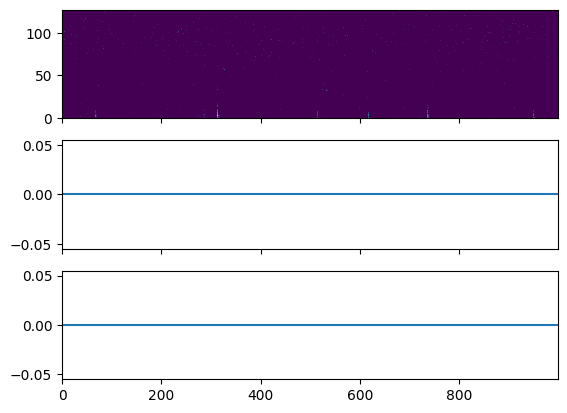

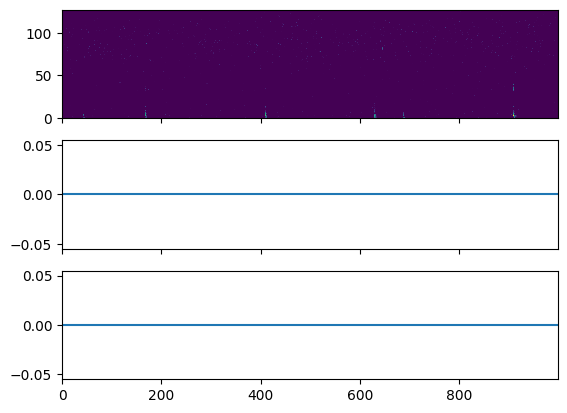

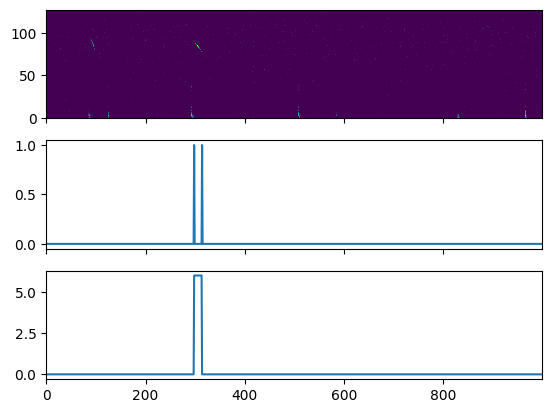

In [16]:
metadata = get_training_replicate_metadata(
    biosound_group='Mouse-Pup-Call',
    id_='MU',
    timebin_dur=1.5,
    unit='call',
    train_dur=1500.,
    replicate_num=1,
    data_source='leave-one-id-out',
)
splits_json_path = biosoundsegbench.prep.constants.DATASET_ROOT / metadata.splits_json_path
plot_examples_train(
    splits_json_path,
    target_type=('boundary_onehot', 'multi_frame_labels'),
    n_windows_to_plot=4,
    window_size=1000,
    standardize=False,
)
plot_examples_val(
    splits_json_path,
    target_type=('boundary_onehot', 'multi_frame_labels'),
    window_size=1000,
    n_windows_to_plot=4,
    standardize=False,
)

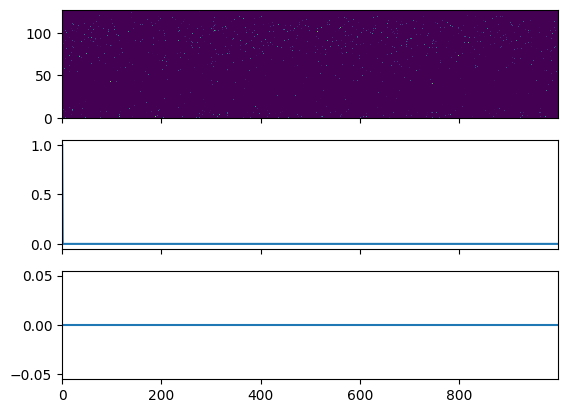

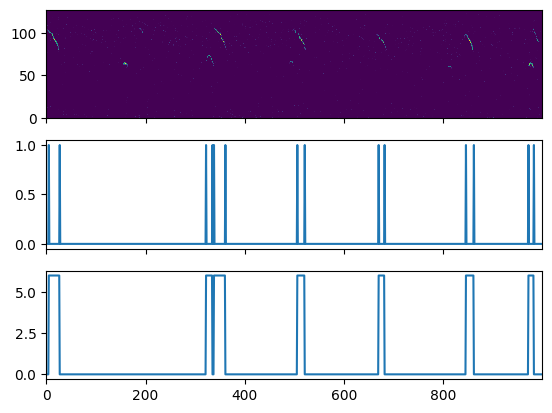

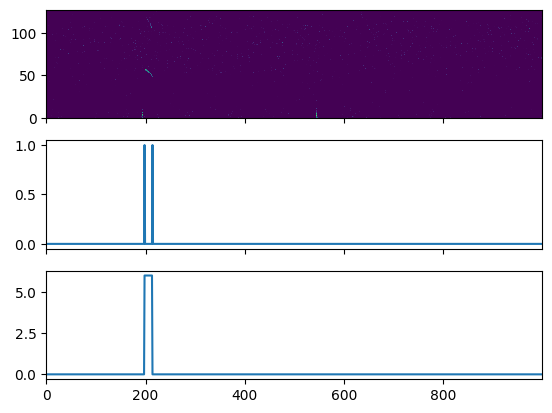

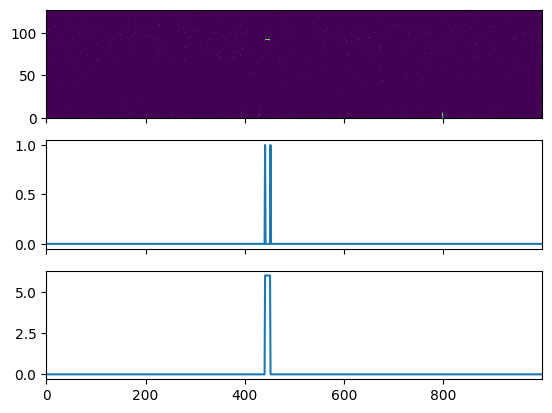

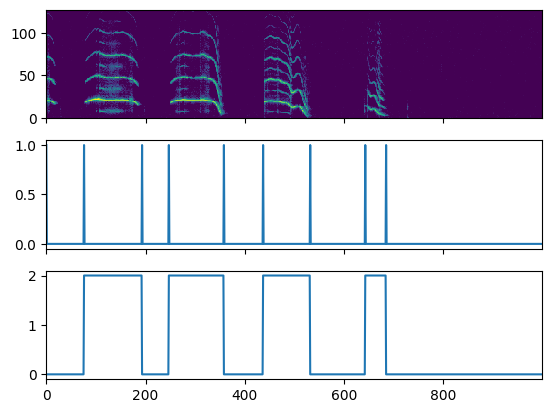

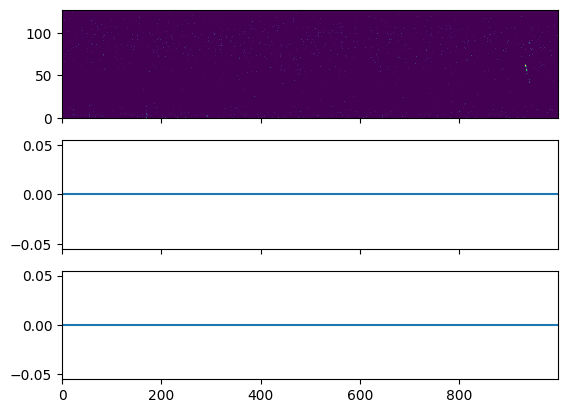

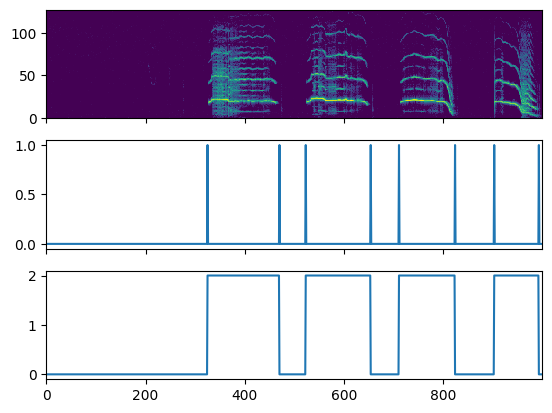

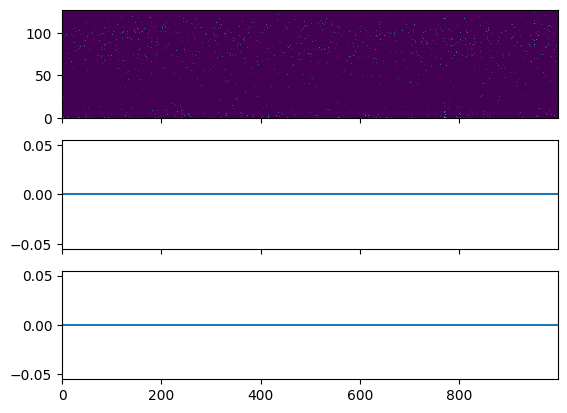

In [17]:
metadata = get_training_replicate_metadata(
    biosound_group='Mouse-Pup-Call',
    id_='BW',
    timebin_dur=1.5,
    unit='call',
    train_dur=1500.,
    replicate_num=1,
    data_source='leave-one-id-out',
)
splits_json_path = biosoundsegbench.prep.constants.DATASET_ROOT / metadata.splits_json_path
plot_examples_train(
    splits_json_path,
    target_type=('boundary_onehot', 'multi_frame_labels'),
    n_windows_to_plot=4,
    window_size=1000,
    standardize=False,
)
plot_examples_val(
    splits_json_path,
    target_type=('boundary_onehot', 'multi_frame_labels'),
    window_size=1000,
    n_windows_to_plot=4,
    standardize=False,
)

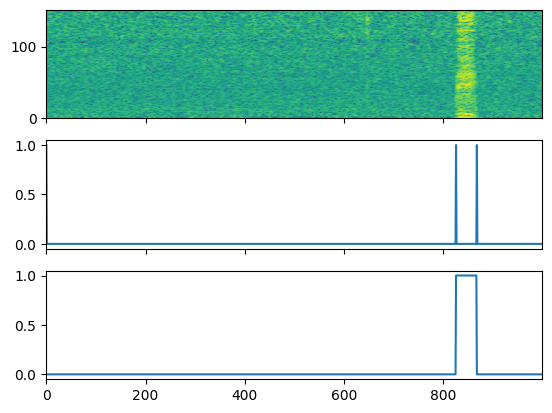

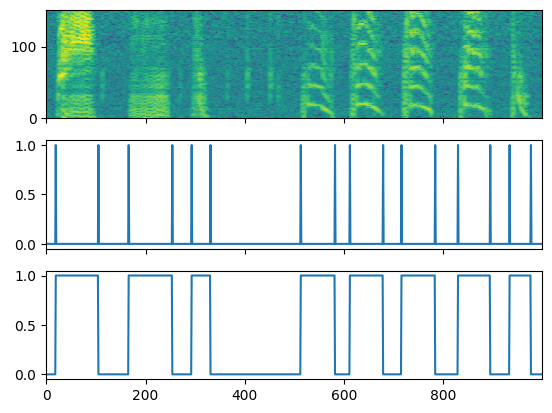

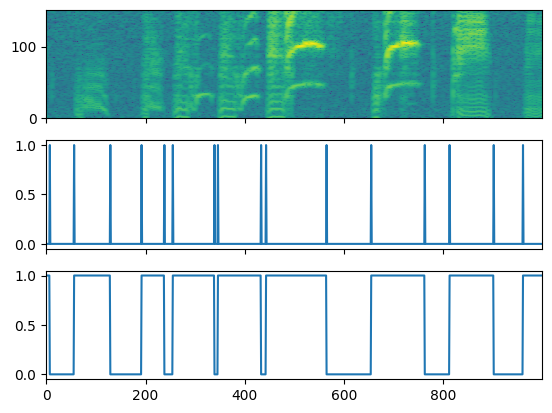

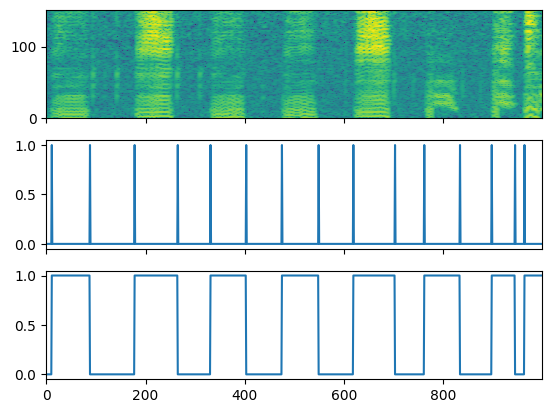

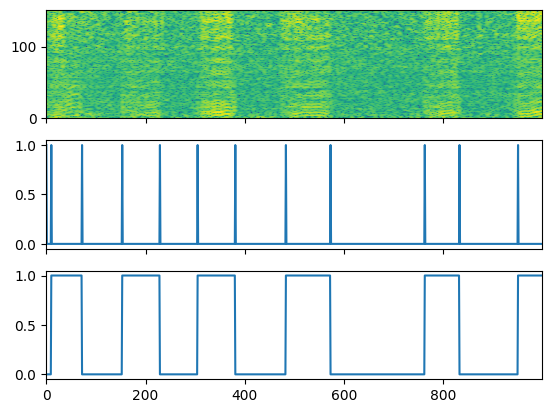

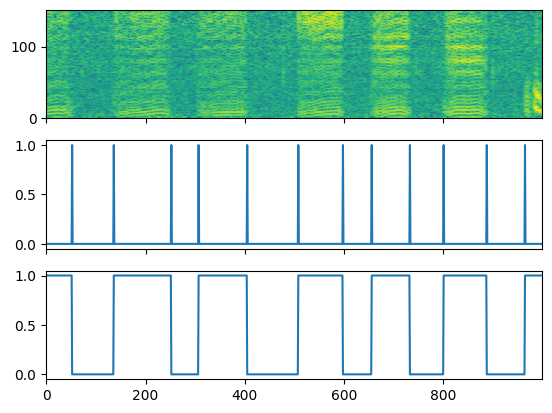

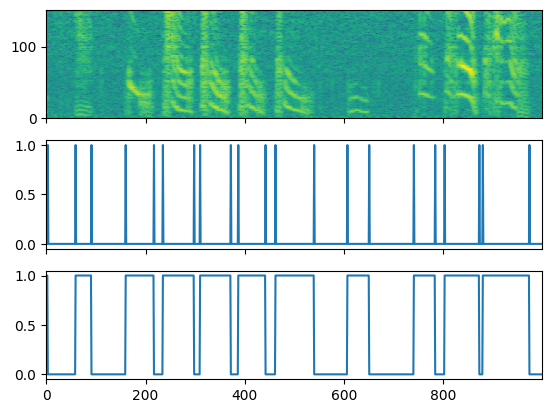

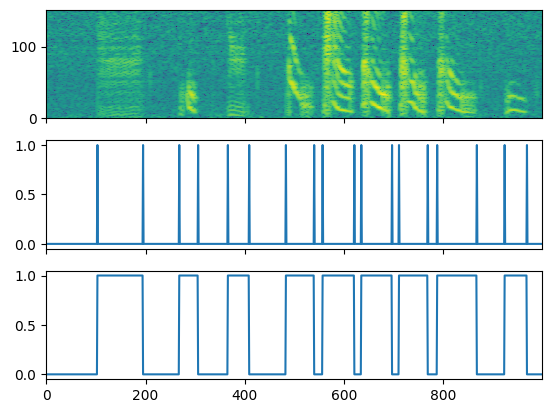

In [18]:
metadata = get_training_replicate_metadata(
    biosound_group='Bengalese-Finch-Song',
    id_='gy6or6',
    timebin_dur=1.0,
    unit='syllable',
    train_dur=600.,
    replicate_num=1,
    data_source='leave-one-id-out',
)
splits_json_path = biosoundsegbench.prep.constants.DATASET_ROOT / metadata.splits_json_path
plot_examples_train(
    splits_json_path,
    target_type=('boundary_onehot', 'binary_frame_labels'),
    n_windows_to_plot=4,
    window_size=1000,
    standardize=True,
)
plot_examples_val(
    splits_json_path,
    target_type=('boundary_onehot', 'binary_frame_labels'),
    window_size=1000,
    n_windows_to_plot=4,
    standardize=True,
)